<a href="https://colab.research.google.com/github/hmazomba/FinMan/blob/notebooks/Preprocessing_Financial_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Getting data from Yahoo Finance using the yfinance module**

*Install Yfinance*



```
# pip install yfinance
```



In [ ]:
!pip install yfinance
%matplotlib inline

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=a659d7c109ef859adae4c820aa6deda7710405fb7ea9cabc61e47fb798bcc72b
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df_apple = yf.download('AAPL', start='2000-01-01', end='2010-12-31', progress=False)
df_apple.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,3.745536,4.017857,3.631696,3.997768,3.460857,133949200
2000-01-04,3.866071,3.950893,3.613839,3.660714,3.169071,128094400
2000-01-05,3.705357,3.948661,3.678571,3.714286,3.215448,194580400
2000-01-06,3.790179,3.821429,3.392857,3.392857,2.937188,191993200
2000-01-07,3.446429,3.607143,3.410714,3.553571,3.076317,115183600


# **Returns: Simple vs Logarithmic**


*Calculating simple and log returns  using Microsoft price 
data*

In [ ]:
df_msft = yf.download('MSFT', start='2000-01-01',
                        end='2010-12-31',
                        progress=False)
df_msft=df_msft.loc[:, ['Adj Close']]
df_msft.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [ ]:
df_msft['simple_rtn'] = df_msft.adj_close.pct_change()
df_msft['log_rtn'] = np.log(df_msft.adj_close/df_msft.adj_close.shift(1))

df_msft.drop('adj_close', axis=1, inplace=True)
df_msft.dropna(axis=0, inplace=True)
df_msft.head()

,simple_rtn,log_rtn
Date,,
2000-01-04,-0.033780,-0.034364
2000-01-05,0.010544,0.010488
2000-01-06,-0.033498,-0.034072
2000-01-07,0.013068,0.012983
2000-01-10,0.007291,0.007265


# **Realized Volatility**



An assessment of variation in returns for an investment product by analyzing its historical returns within a defined time period. In statistics, the most common measure to determine variability is by measuring the standard deviation, i.e variability of returns from the mean. It is an indicator of the actual price risk.

***Measured by***: calculating the standard deviation from the average price of an asset in a given time period



In [ ]:
#Realized Volatility method
def realized_volatility(x):
  return np.sqrt(np.sum(x**2))

In [ ]:
#Calculate monthly realized volatility
df_rv = df_msft.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)

#Annualize values
df_rv.rv = df_rv.rv * np.sqrt(12)


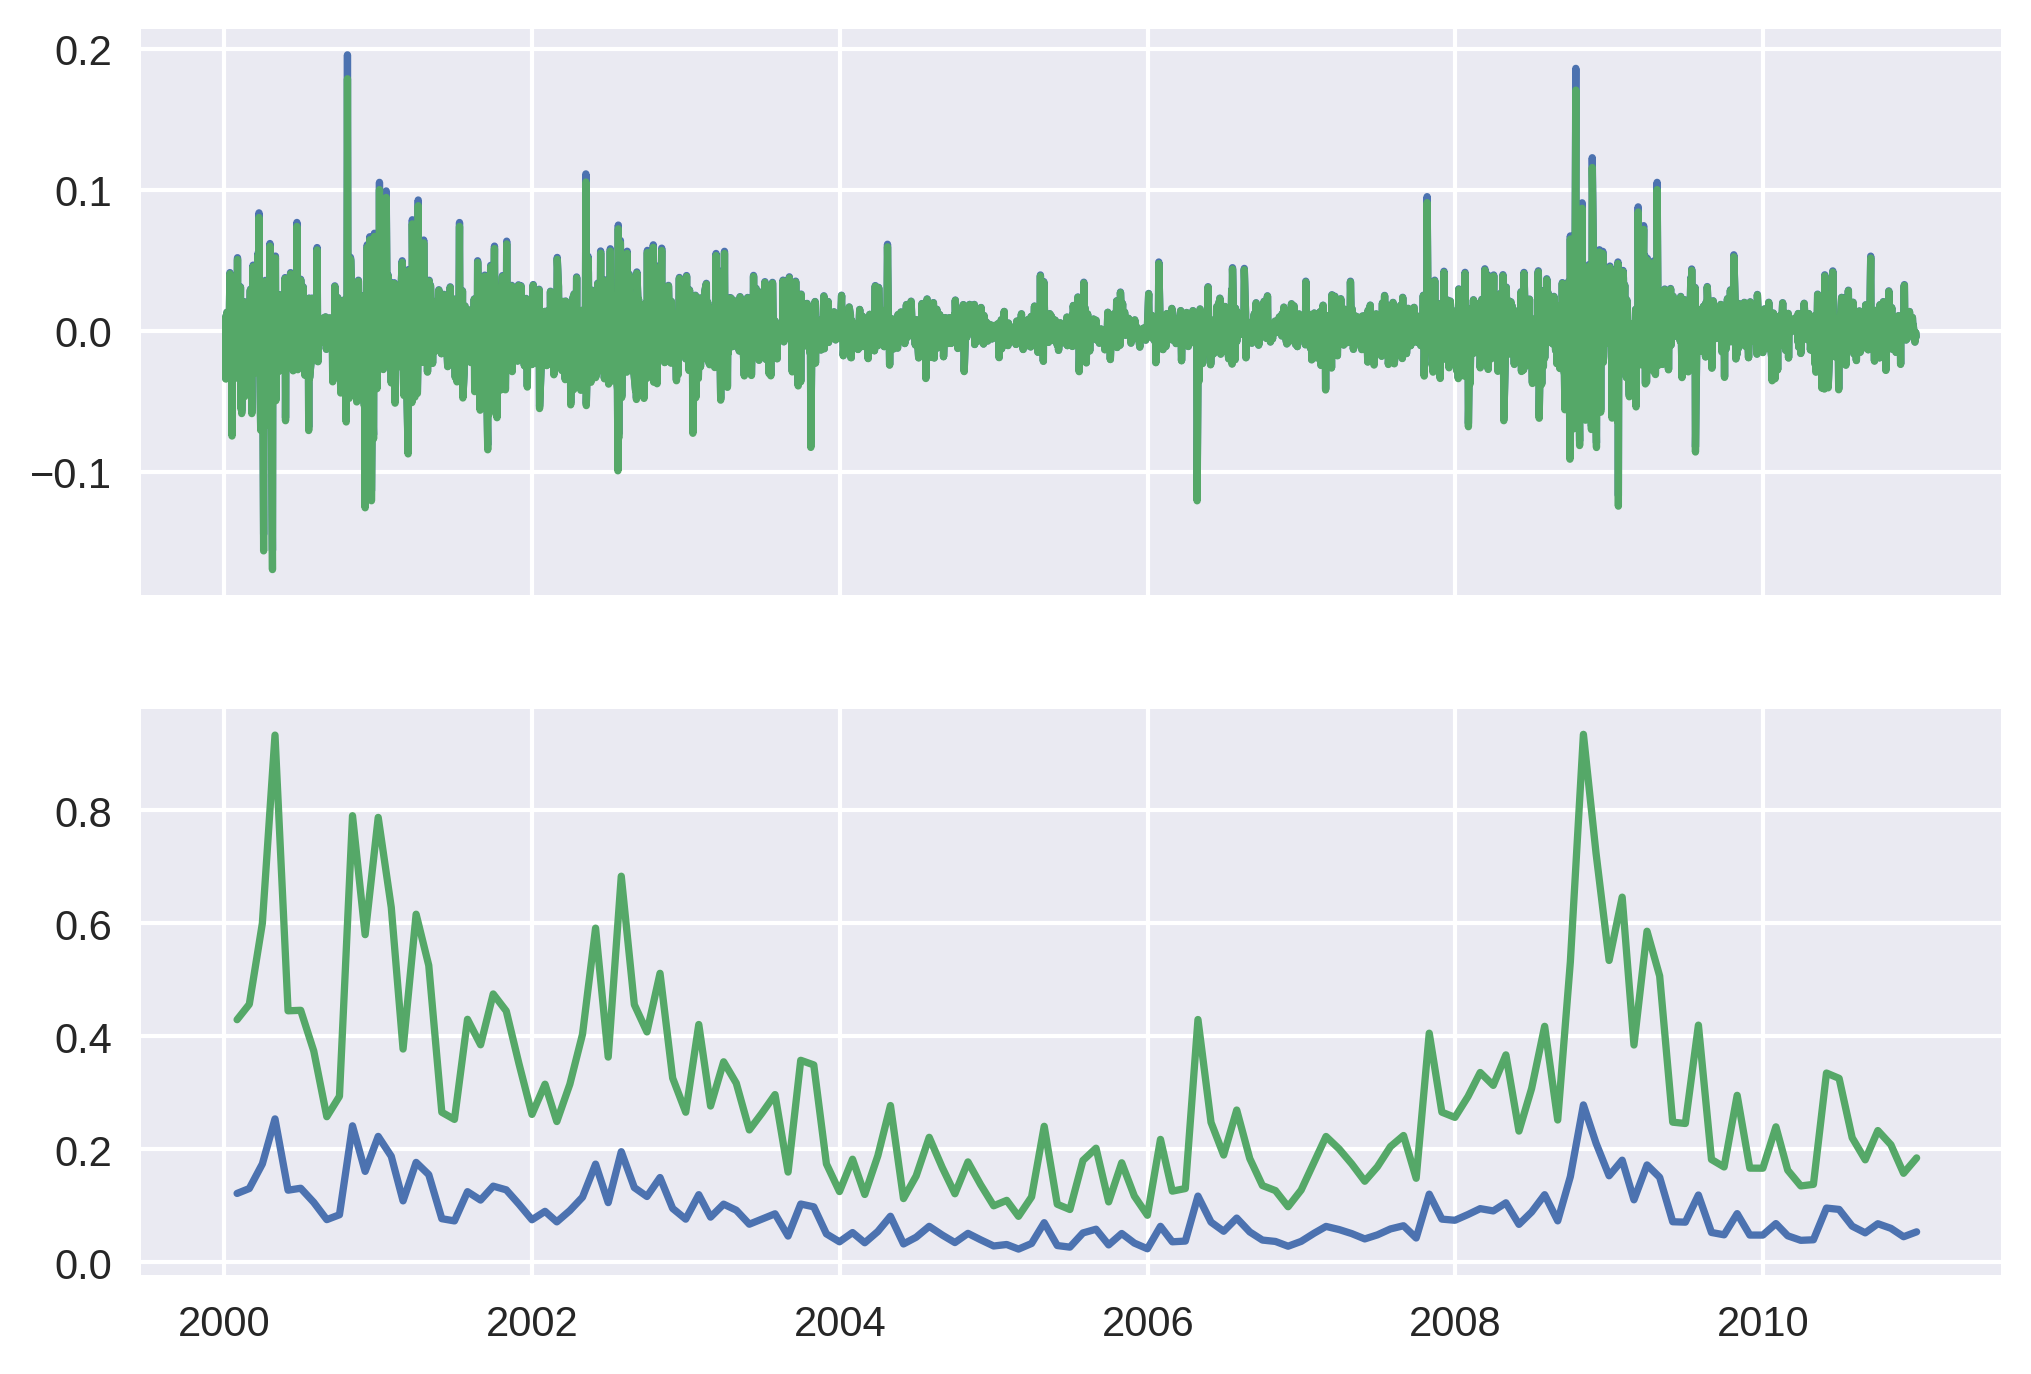

In [ ]:
#Plot the results
fig, ax = plt.subplots(2, 1,sharex=True)
ax[0].plot(df_msft)
ax[1].plot(df_rv)

plt.show()

# **Outliers**

*Plotting outliers using matplotlib*


In [ ]:
df_apple=yf.download('AAPL', start='2000-01-01',
                     end='2010-12-31',
                     progress=False)


df_apple=df_apple.loc[:, ['Adj Close']]
df_apple.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [ ]:
df_apple['simple_rtn'] = df_apple.adj_close.pct_change()

In [ ]:
df_rolling = df_apple[['simple_rtn']].rolling(window=21)\
                                      .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [ ]:
df_outliers = df_apple.join(df_rolling)

In [ ]:
def indentify_outliers(row, n_sigma=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if(x > mu + 3 * sigma) | (x < mu - 3 * sigma):
      return 1
    else:
      return 0    

In [ ]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, 
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

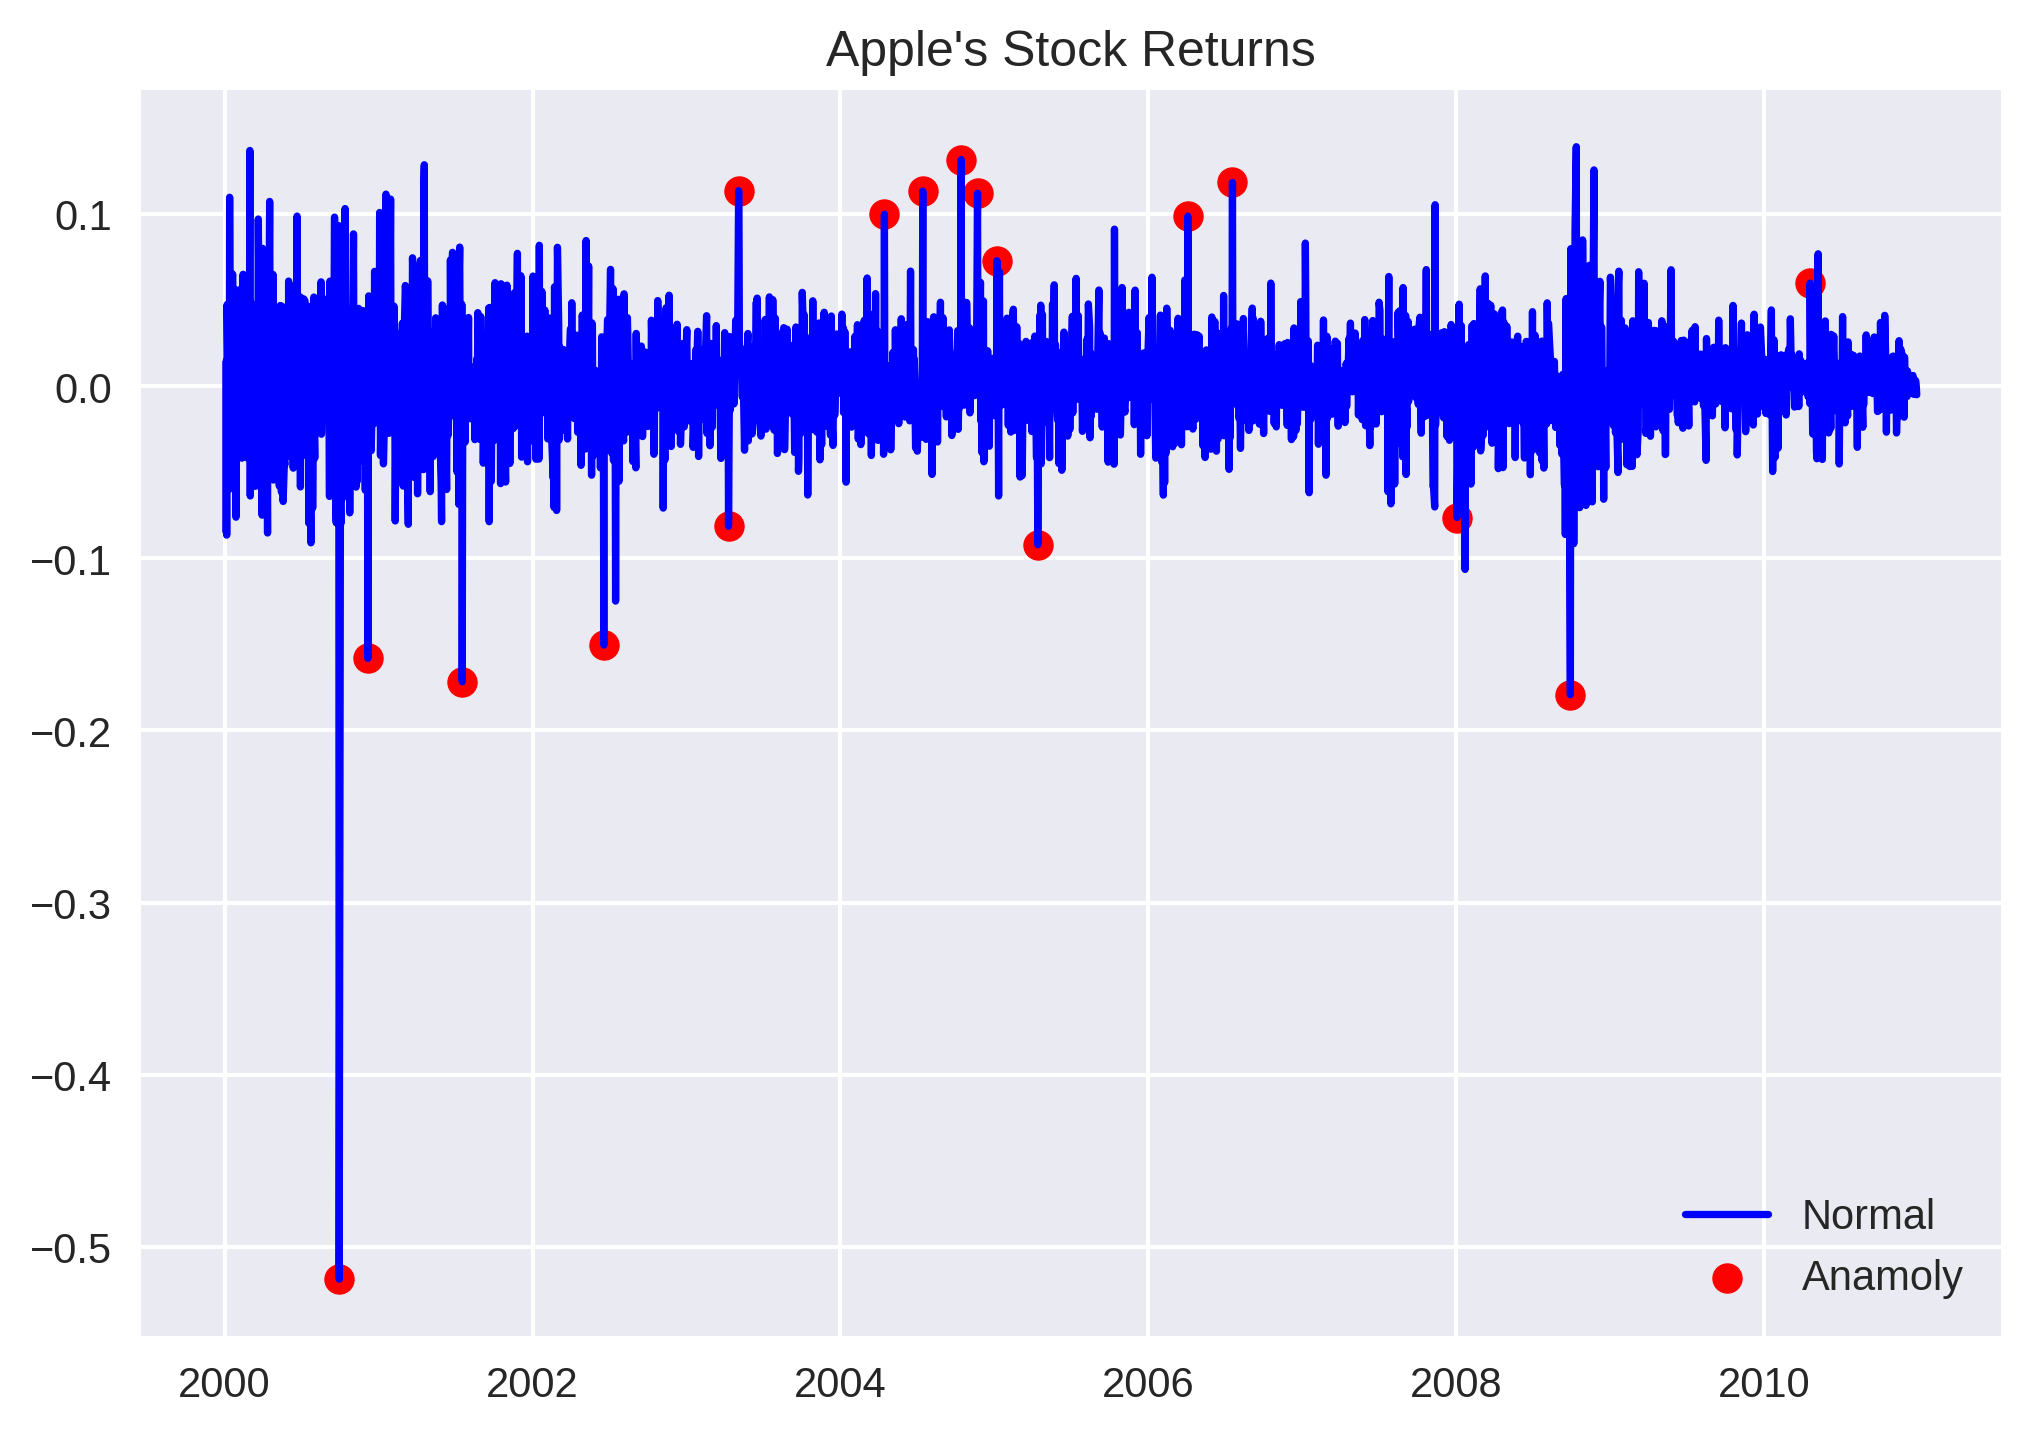

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_outliers.index, df_outliers.simple_rtn,
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn,
           color='red', label='Anamoly')
ax.set_title("Apple's Stock Returns")
ax.legend(loc='lower right')

# **Stylized Facts**


***Stylized facts*** are statistical properties that appear to be present in many empirical asset returns (across time and markets)

In [ ]:
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [ ]:
#download Microsoft's Stock Prices
df_spfive = yf.download('^GSPC',
                        start='1985-01-01',
                        end='2018-12-31',
                        progress=False)

df_spfive= df_spfive[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df_spfive['log_rtn'] = np.log(df_spfive.adj_close/df_spfive.adj_close.shift(1))
df_spfive = df_spfive[['adj_close', 'log_rtn']].dropna(how='any')

In [ ]:
r_range = np.linspace(min(df_spfive.log_rtn), max(df_spfive.log_rtn), num=1000)
mu = df_spfive.log_rtn.mean()
sigma=df_spfive.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

Text(0.5, 1.0, 'Q-Q plot')

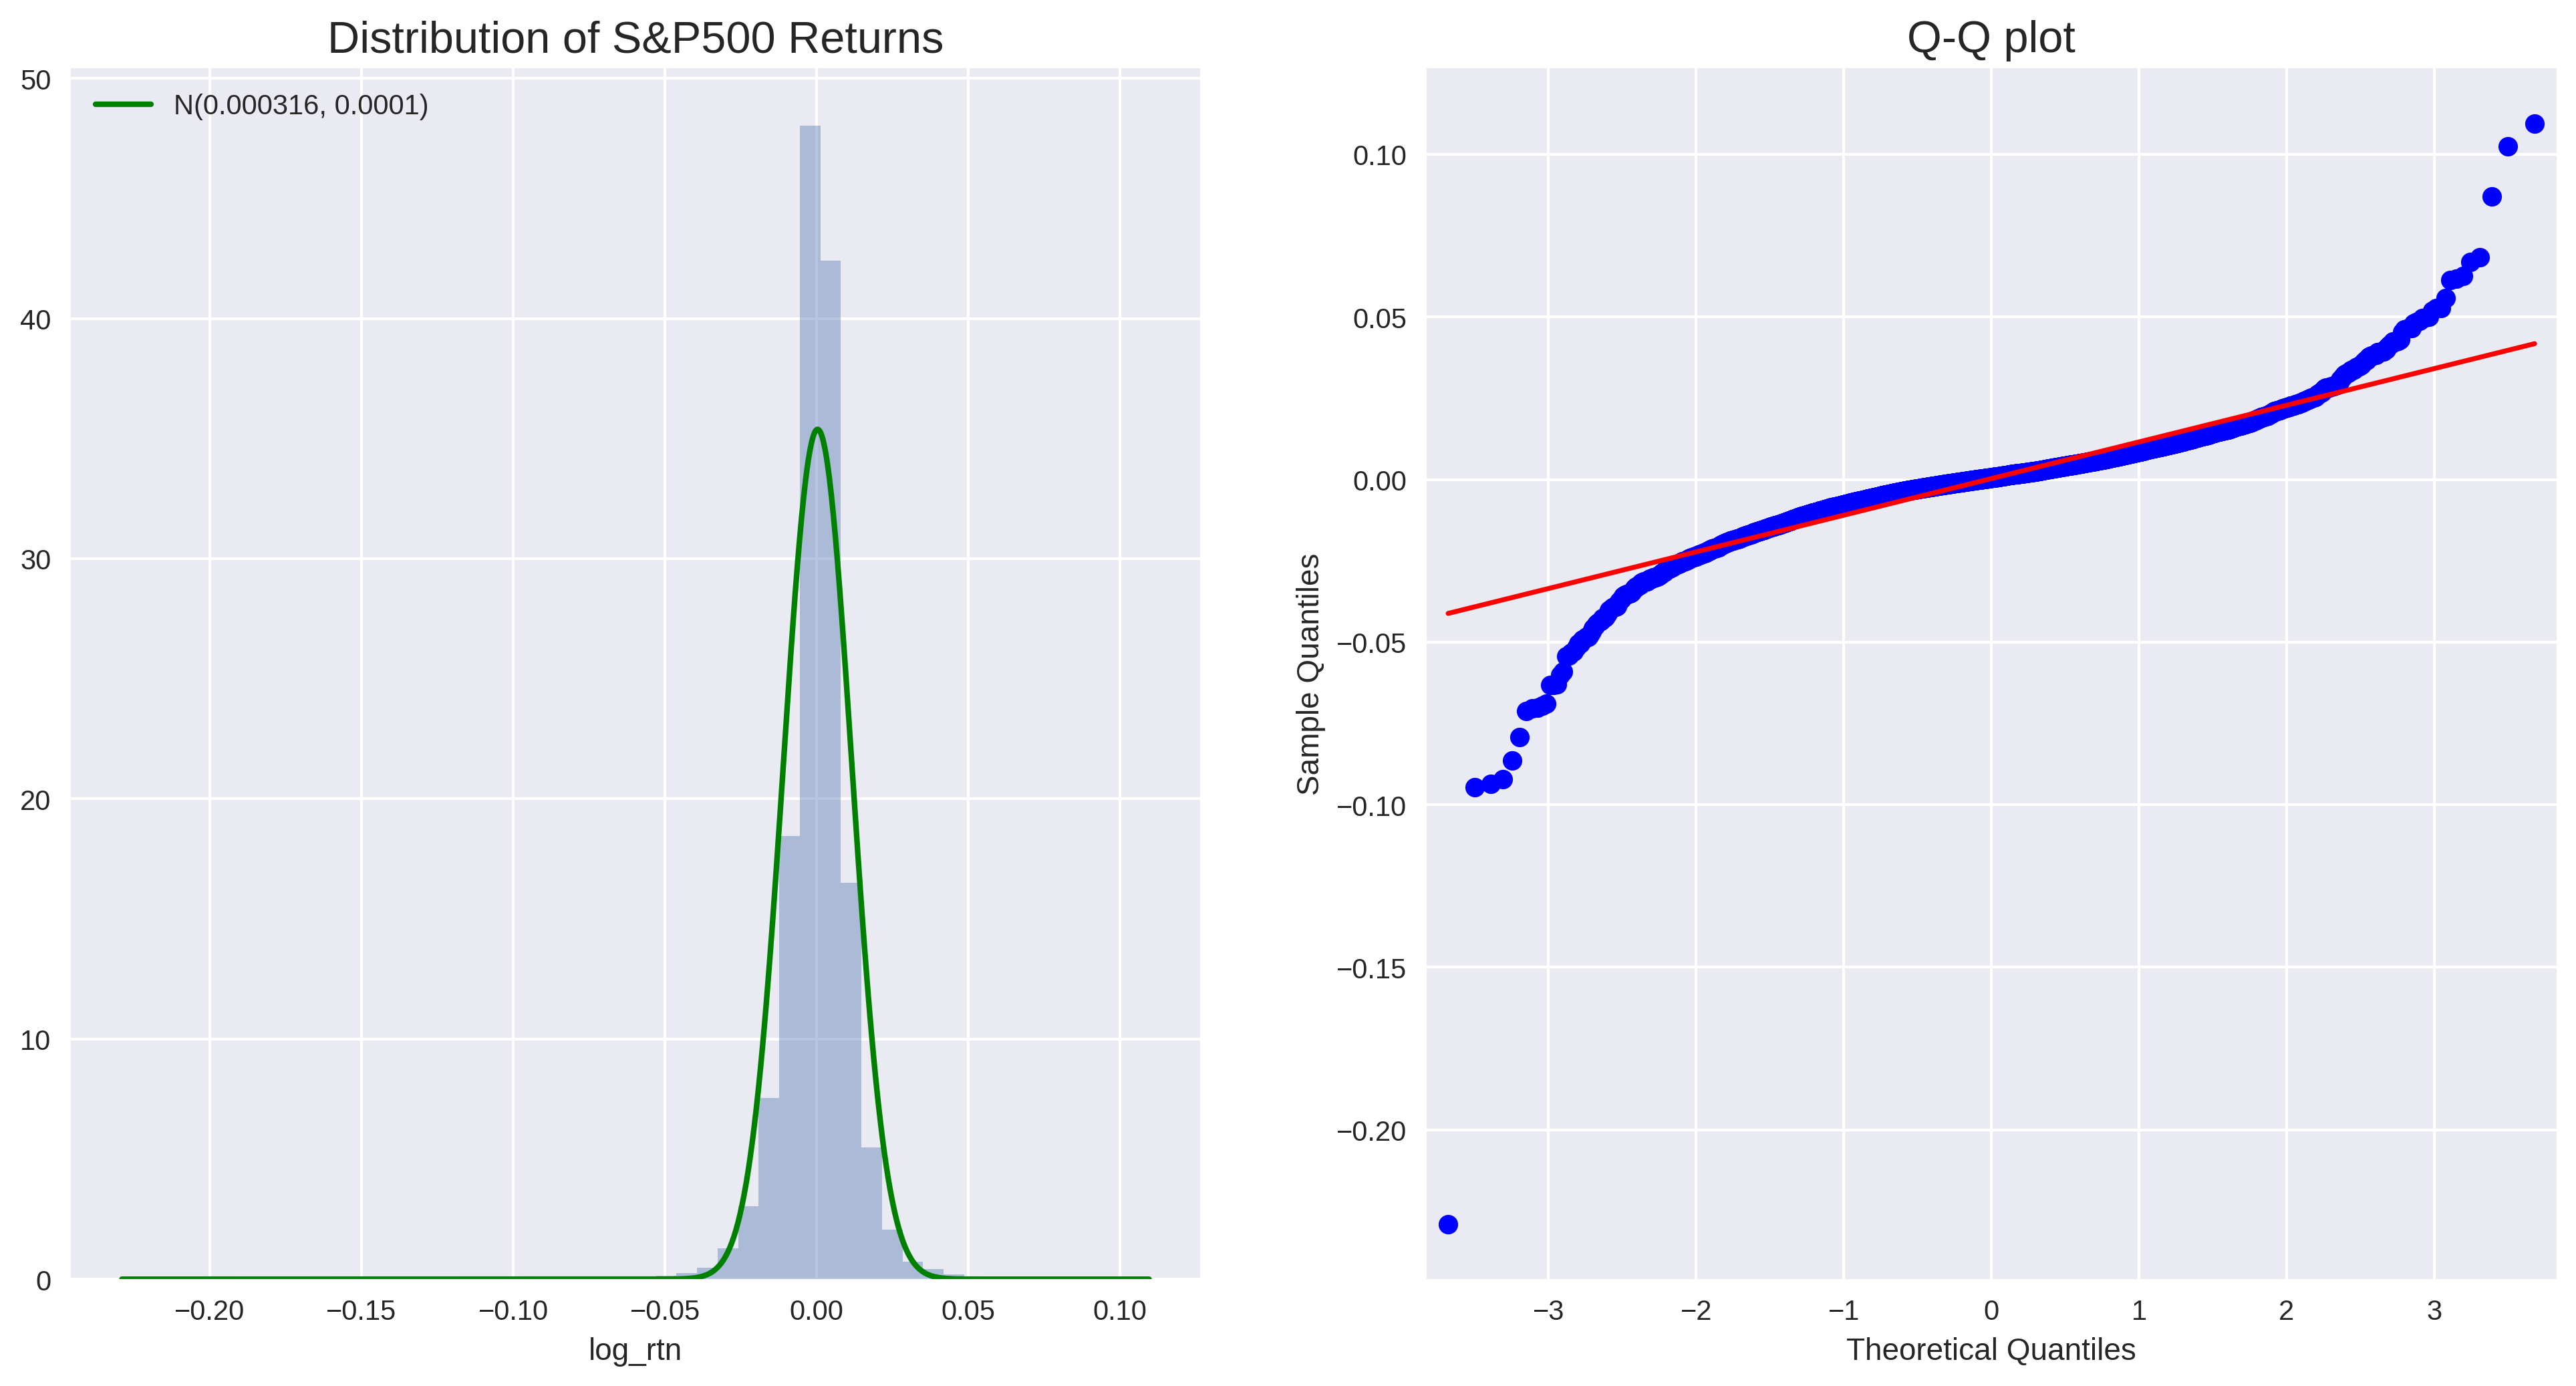

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df_spfive.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of S&P500 Returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2,
           label=f'N({mu:2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

#Q-Q Plot
qq = sm.qqplot(df_spfive.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize=16)

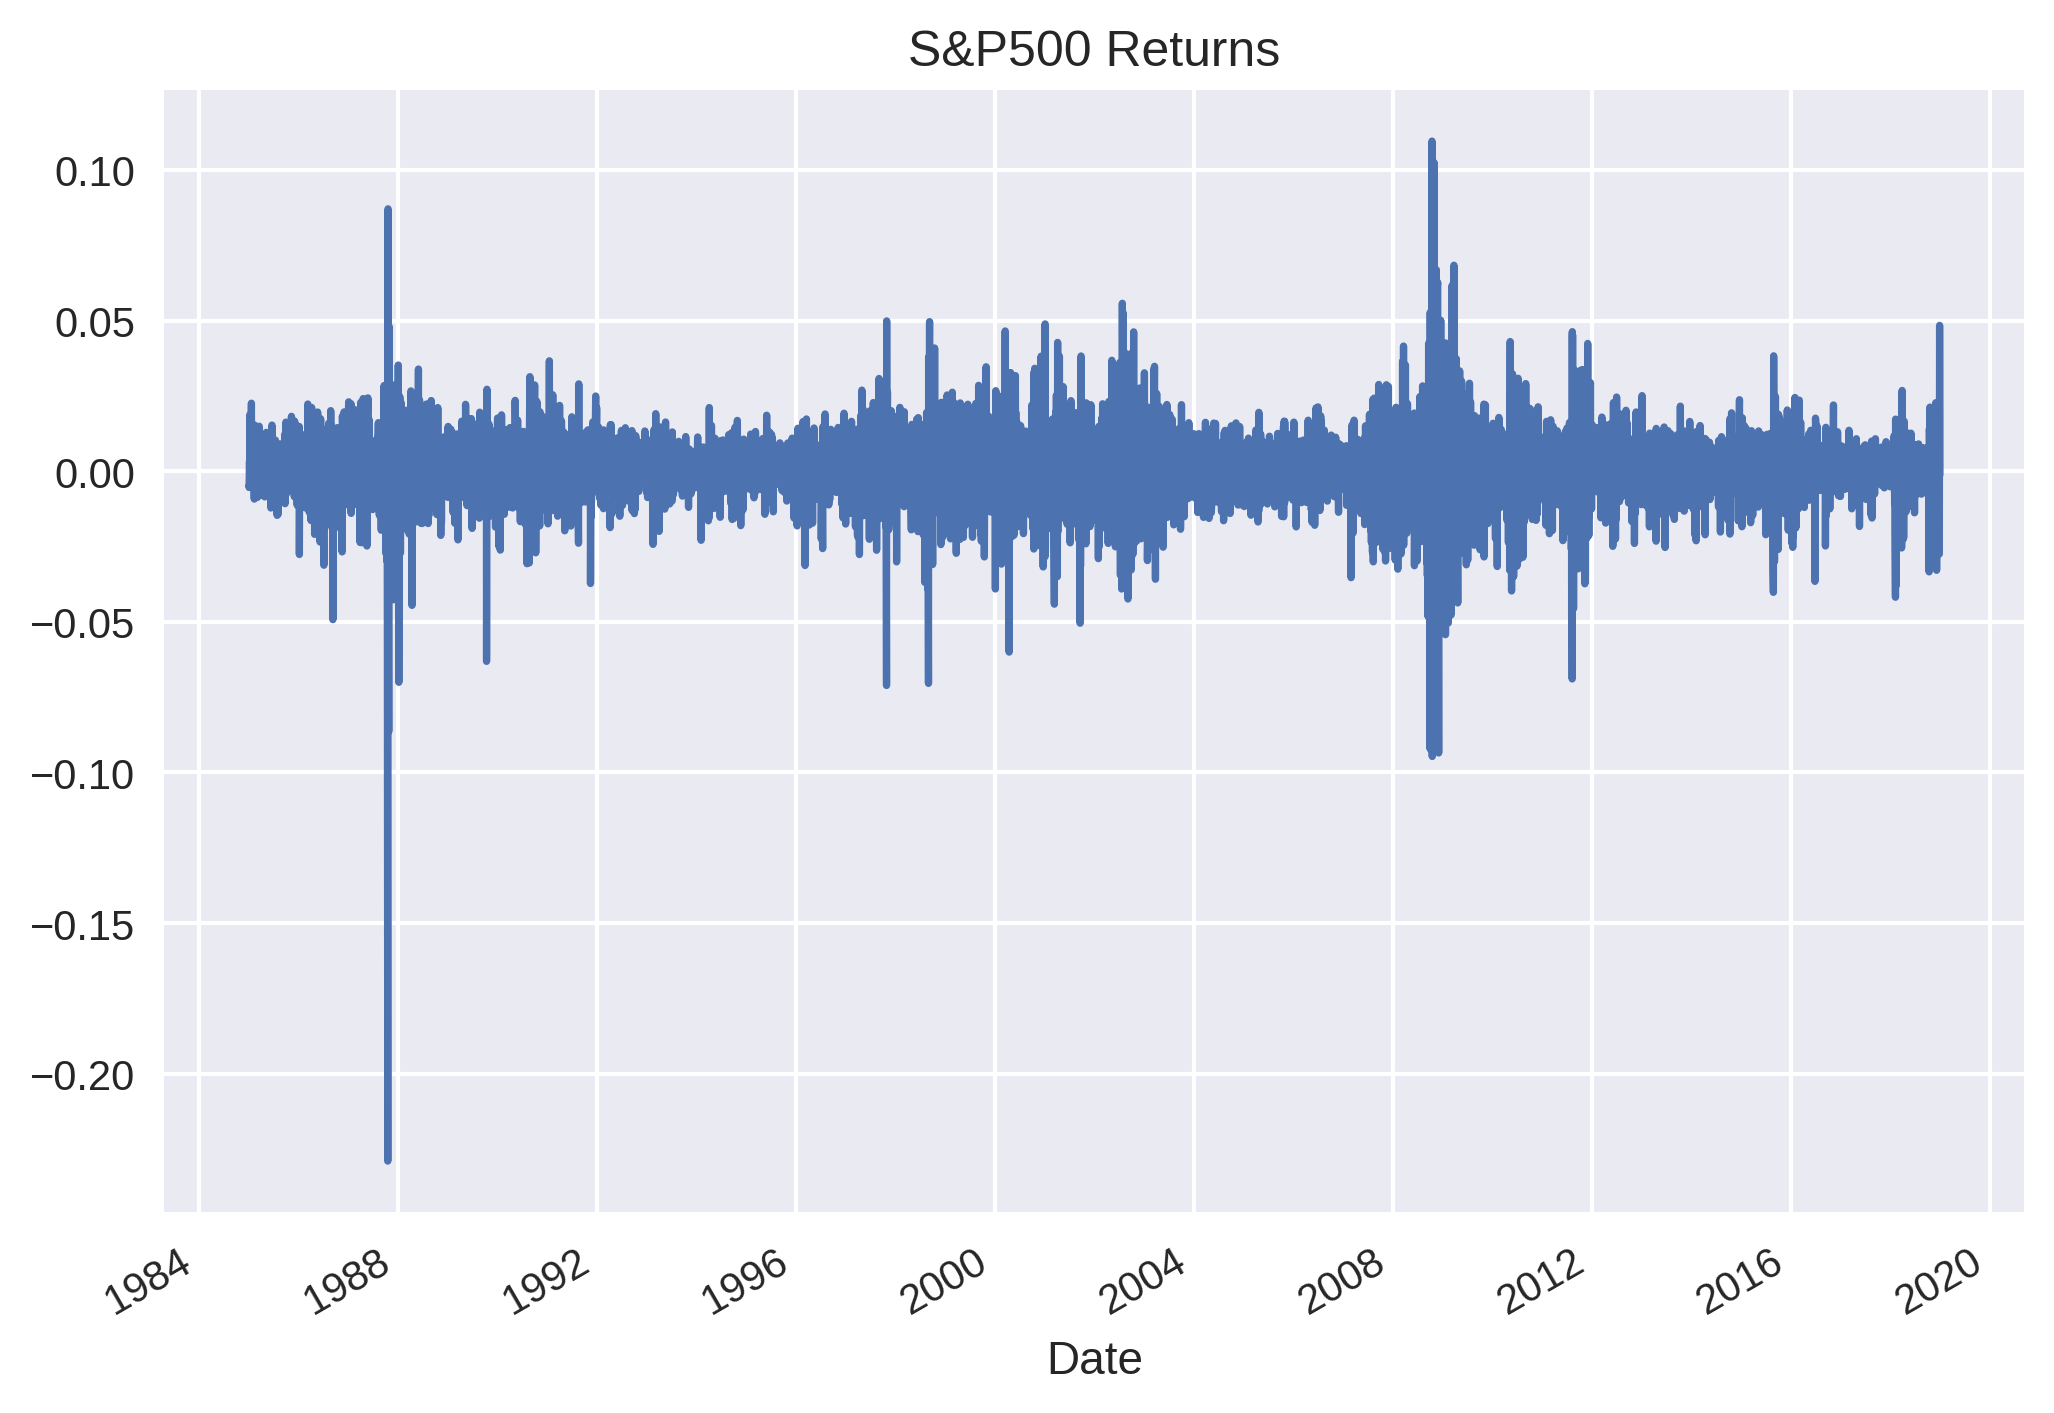

In [ ]:
df_spfive.log_rtn.plot(title='S&P500 Returns')

# **Autocorrelation**

Autocorrelation measures the relationship between a variable's current value and its past values. In Finance, it is used to see how much of an impact past prices for a security have on its future price.

In [ ]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

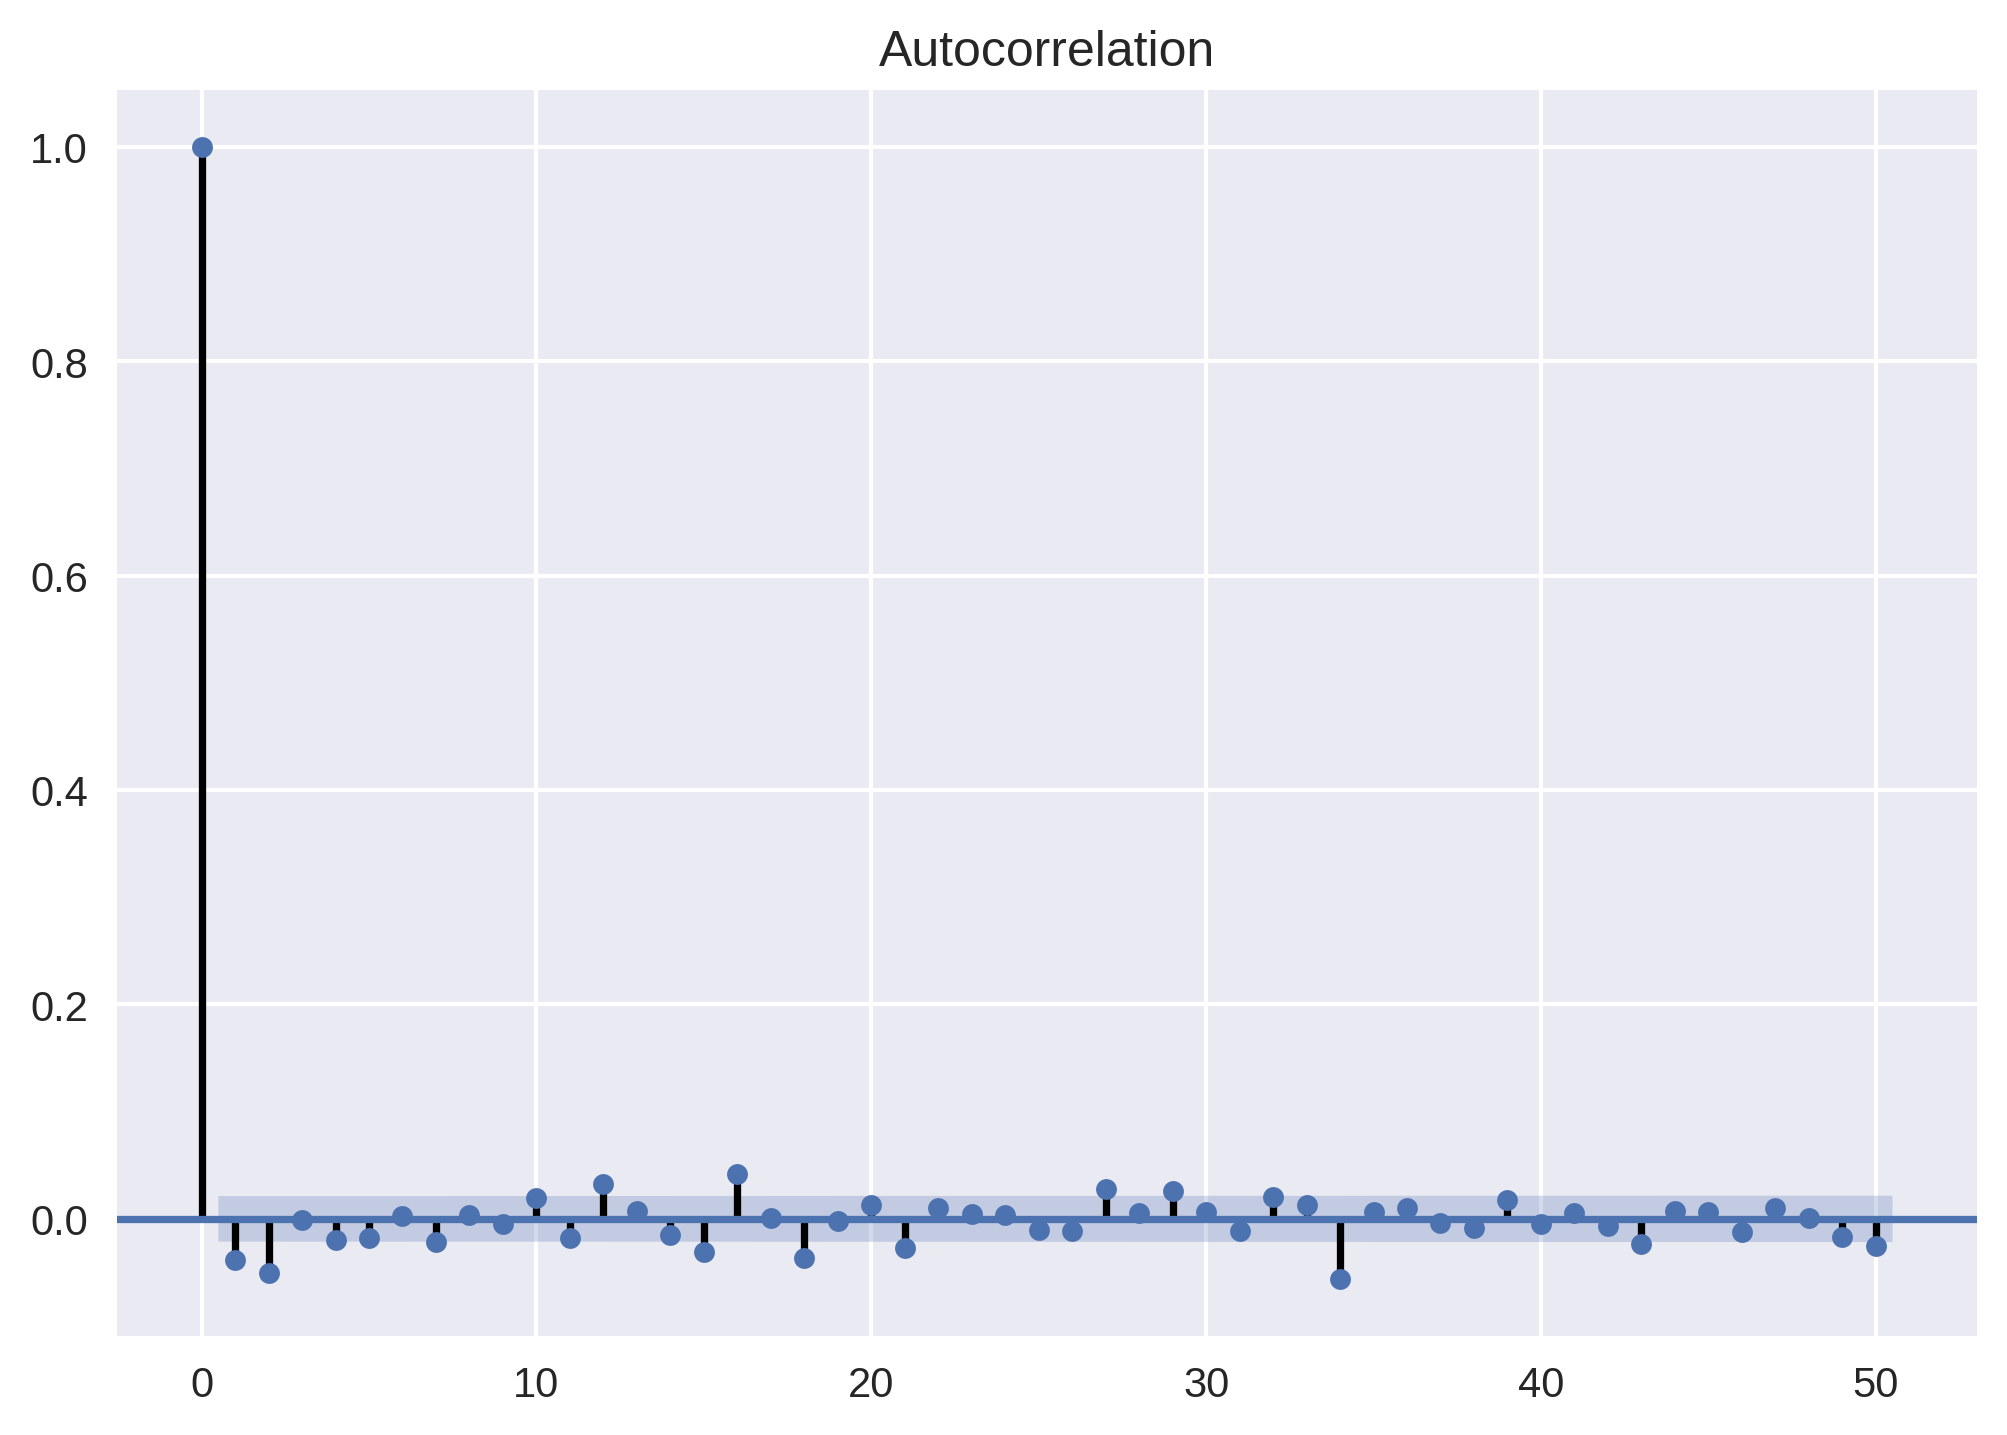

In [ ]:
acf = smt.graphics.plot_acf(df_spfive.log_rtn, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.show()

The above graph indicates an absence of autocorrelation in this time series

**Looking for autocorrelation in squared/absolute returns**


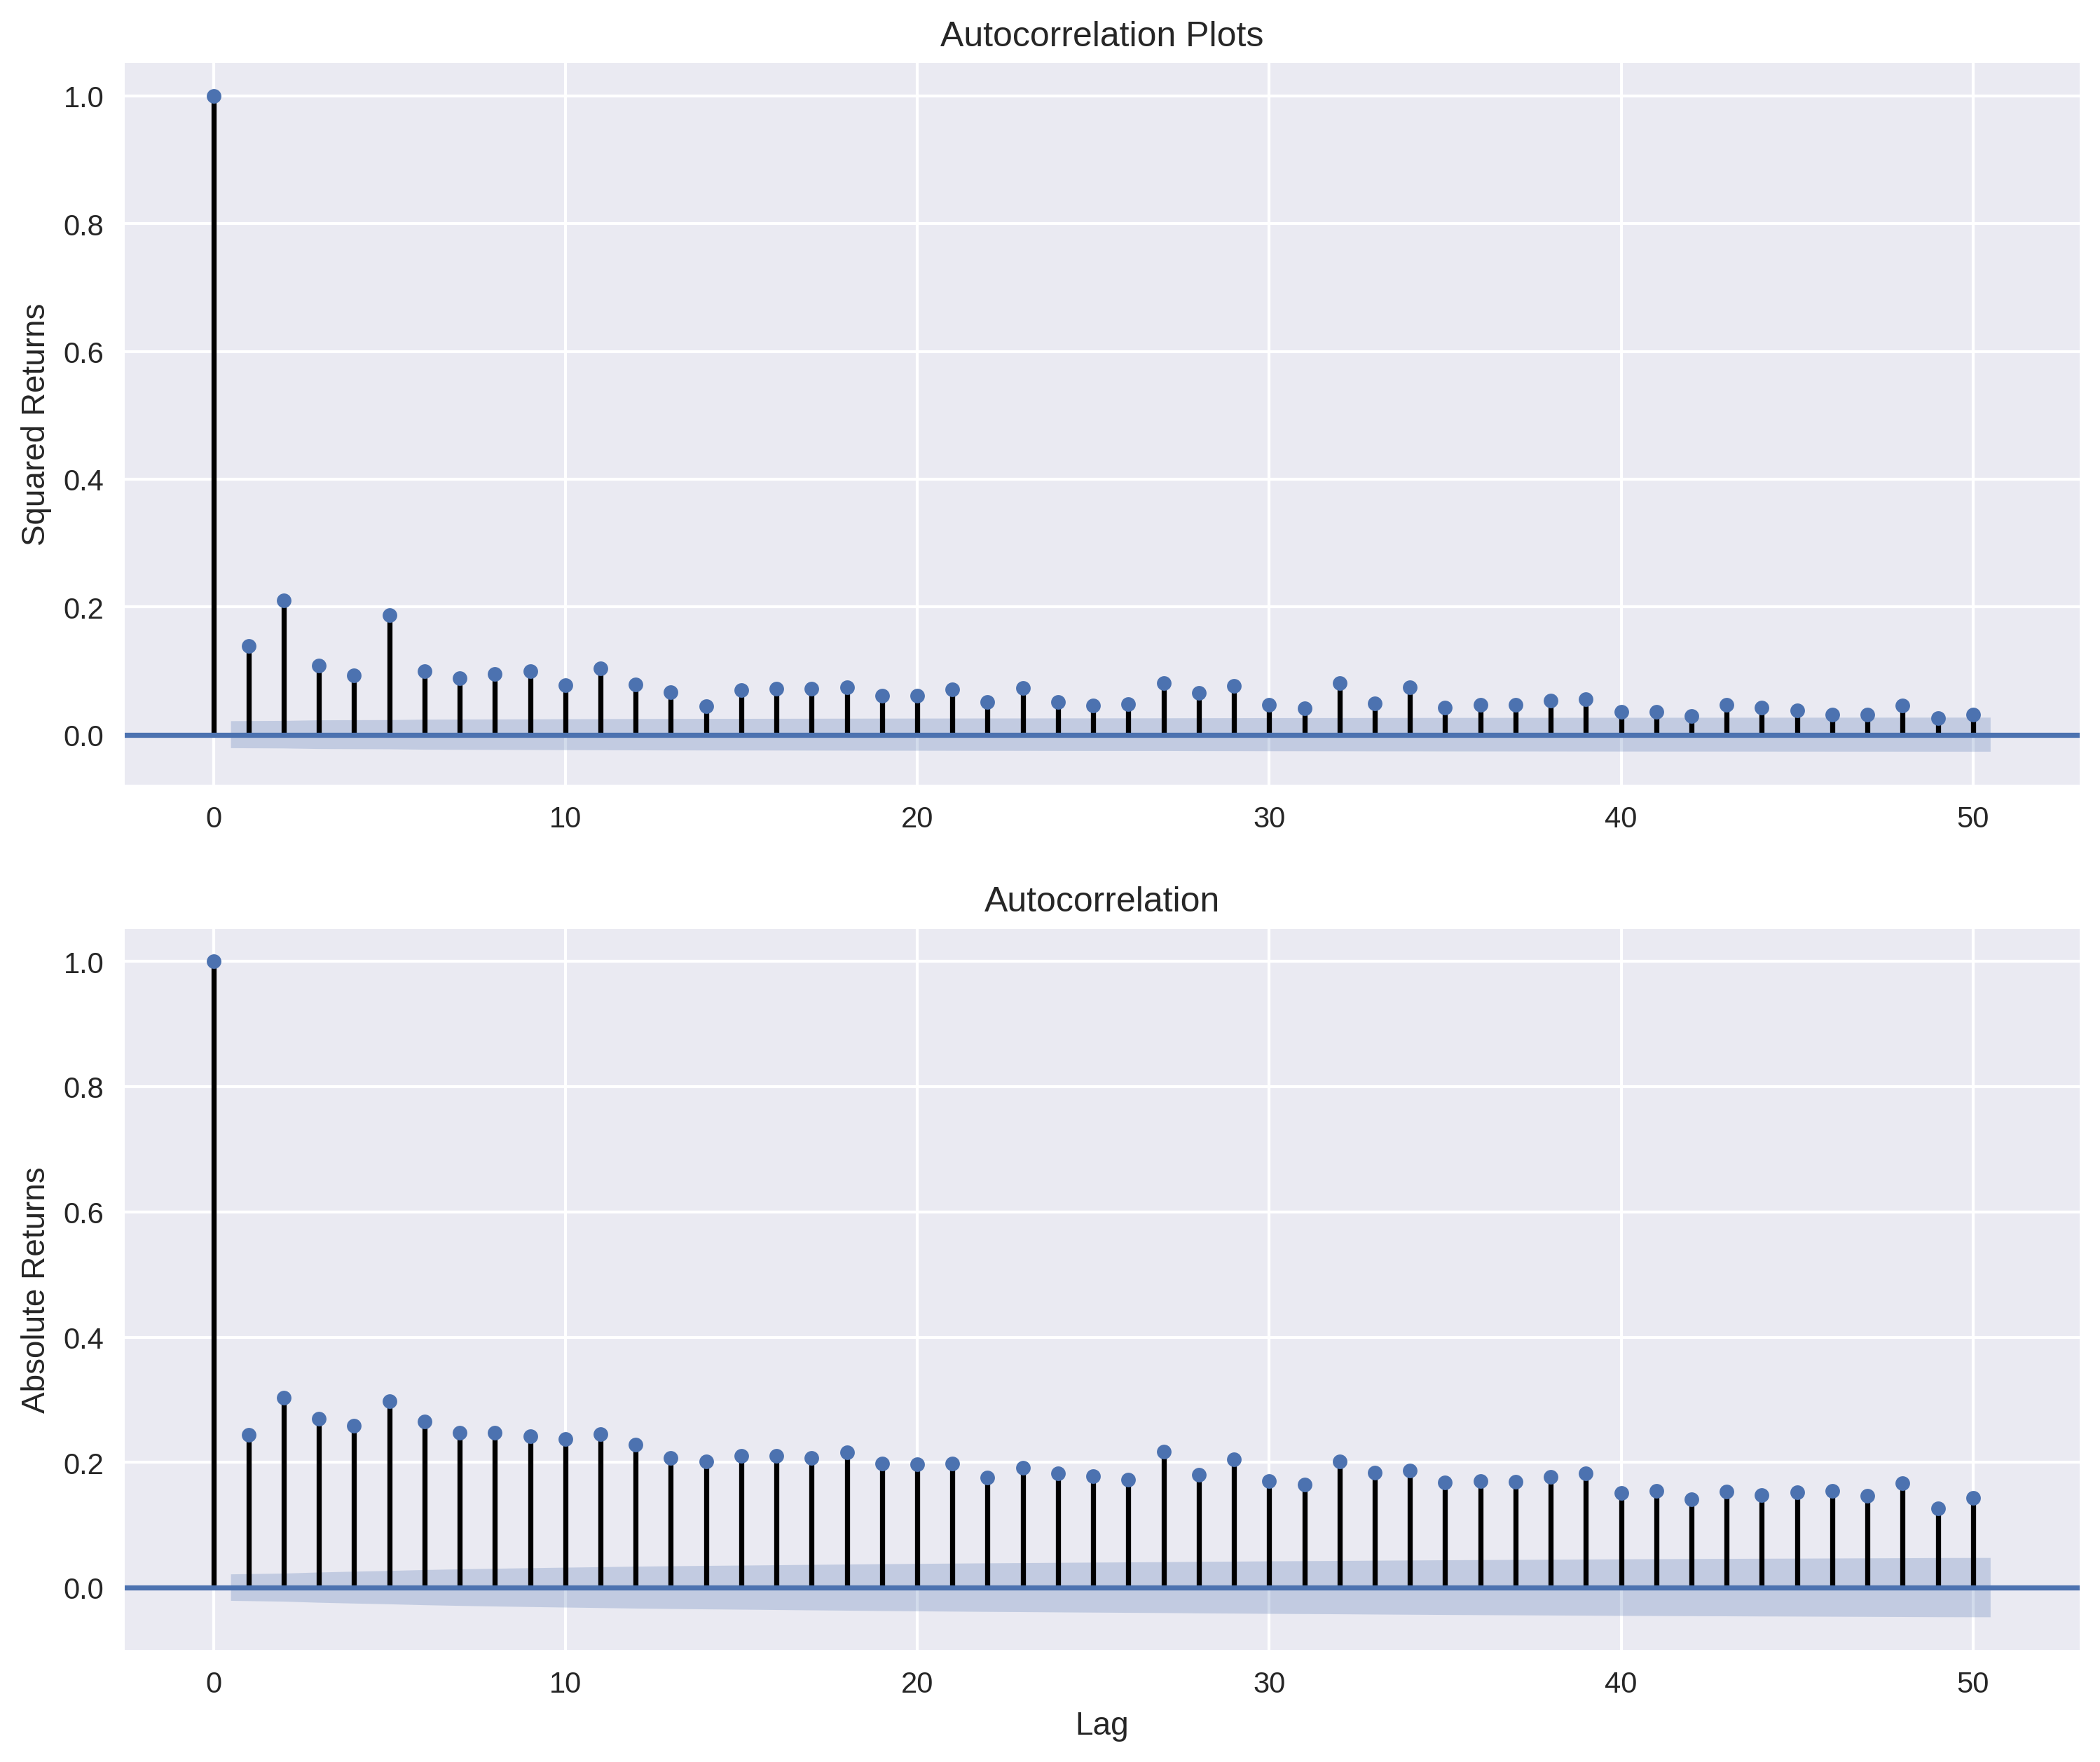

In [ ]:
fig, ax =plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df_spfive.log_rtn**2, lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')
smt.graphics.plot_acf(np.abs(df_spfive.log_rtn), lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

plt.show()

# **Leverage Effect**

***The leverage effect*** refers to the tendency of an asset's volatility to be negatively correlated with the asset's returns. Typically rising asset prices are accompanied by declining volatility and vice versa.

***In economic terms***: as asset prices decline, companies become more mechanically leveraged. The relative value of their debt rises relatives to that of their equity. Therefore the asset becomes riskier hence the rise in volatility.

In [ ]:
df_spfive['moving_std_252'] = df_spfive[['log_rtn']].rolling(window=252).std()
df_spfive['moving_std_21'] = df_spfive[['log_rtn']].rolling(window=21).std()

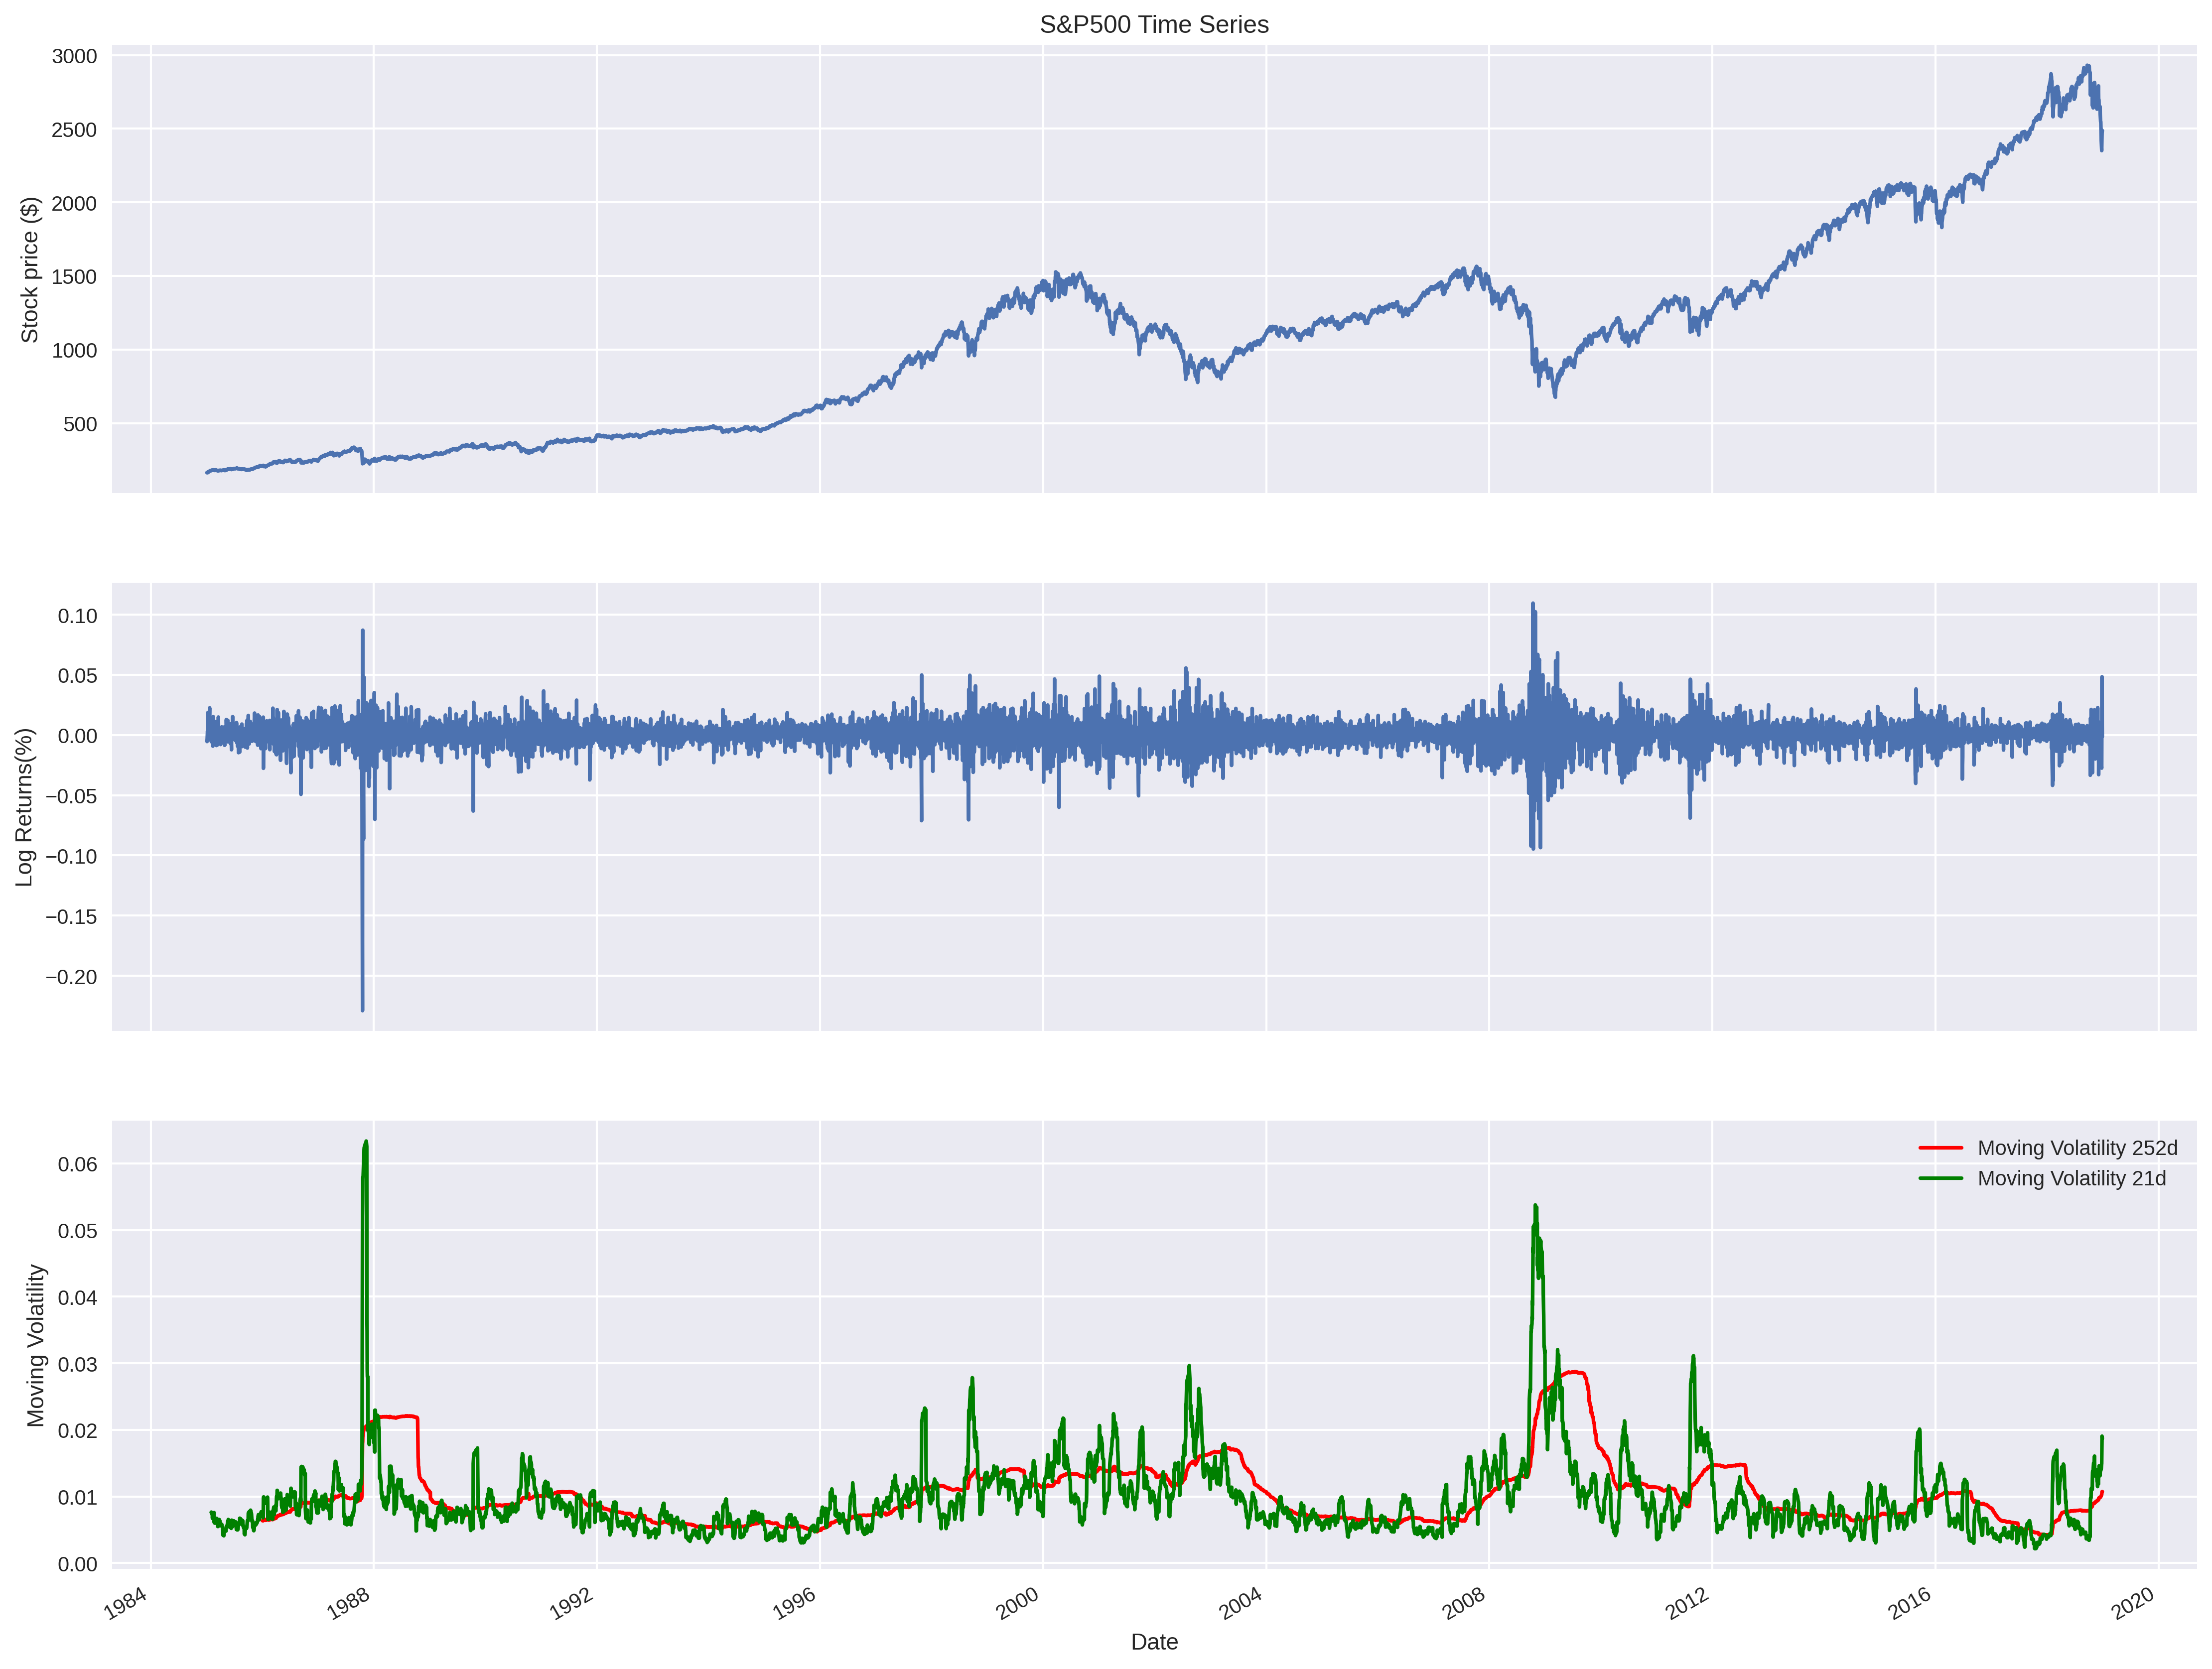

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15),
                       sharex=True)
df_spfive.adj_close.plot(ax=ax[0])
ax[0].set(title='S&P500 Time Series',
          ylabel='Stock price ($)')

df_spfive.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log Returns(%)')

df_spfive.moving_std_252.plot(ax=ax[2], color='r', label='Moving Volatility 252d')
df_spfive.moving_std_21.plot(ax=ax[2], color='g', label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility',
          xlabel='Date')
ax[2].legend()

plt.show()